In [1]:
import py21cmfast as p21c
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
import astropy.units as un
from py21cmfast.io.caching import RunCache, CacheConfig

from matplotlib import rcParams
rcParams.update({"font.size":20, "font.family": 'serif'})
from matplotlib import colormaps, colors
from matplotlib.ticker import AutoLocator

eor_colour = colors.LinearSegmentedColormap.from_list(
    "EoR",
    [
        (0, "white"),
        (0.21, "yellow"),
        (0.42, "orange"),
        (0.63, "red"),
        (0.86, "black"),
        (0.9, "blue"),
        (1, "cyan"),
    ],
)
try:
    colormaps.register(cmap=eor_colour)
except:
    pass

In [ ]:
F_STAR10                    = 10**(-0.281E+01) *cosmo.Om0 / cosmo.Ob0
SIGMA_STAR                  = 0.2393
t_STAR                      = 0.1676E+00
ALPHA_STAR                  = 0.4709E+00
SIGMA_SFMS_0                = 0.9297E-01
SIGMA_SFR_INDEX             = -0.1884E-01
UPPER_STELLAR_TURNOVER_MASS = 0.1444E+02
SIGMA_UV                    = 0.244947465229813069E+00

In [2]:
plotspath = "/home/dbreitman/EOS25/EOS25_summaries/"
cachedir = '/projects/cosmo_database/dbreitman/EOS25/ASTRO_PARAMS_ST_MAP_BIG_FINAL/'
cache = p21c.OutputCache(cachedir)
lightcone = p21c.LightCone.from_file(cachedir+"lc")
inputs = p21c.InputParameters.from_template("/home/dbreitman/EOS25/EOS25/EOS25_astro_ST.toml", 
                                            random_seed=1234,
                                           node_redshifts=p21c.wrapper.inputs.get_logspaced_redshifts(
        min_redshift=5.0,
        z_step_factor=1.02,
        max_redshift=35.0,
    ),).evolve_input_structs(BOX_LEN=96*4, HII_DIM=64*4, DIM=192*4, SAMPLER_MIN_MASS=10**(9.71), N_THREADS=4)
runcache = RunCache.from_inputs(inputs, cache=cache)

In [3]:
F_STAR10                    = inputs.astro_params.F_STAR10
ALPHA_STAR                  = inputs.astro_params.ALPHA_STAR
t_STAR                      = inputs.astro_params.t_STAR

F_STAR7_MINI                = inputs.astro_params.F_STAR7_MINI
ALPHA_STAR_MINI             = inputs.astro_params.ALPHA_STAR_MINI

F_ESC10                     = inputs.astro_params.F_ESC10
ALPHA_ESC                   = inputs.astro_params.ALPHA_ESC
F_ESC7_MINI                 = inputs.astro_params.F_ESC7_MINI

BOX_LEN=96*4
HII_DIM=64*4
DIM=192*4

UPPER_STELLAR_TURNOVER_MASS = inputs.astro_params.UPPER_STELLAR_TURNOVER_MASS
UPPER_STELLAR_TURNOVER_INDEX = inputs.astro_params.UPPER_STELLAR_TURNOVER_INDEX
M_turn=inputs.astro_params.M_TURN

In [4]:
def get_M_ast(f_ast, alpha_ast, M_h, M=10):
    if not hasattr(f_ast, "__len__"):
        f_ast = np.array([f_ast])
    if not hasattr(alpha_ast, "__len__"):
        alpha_ast = np.array([alpha_ast])
    M = 10**(M)#M_sun
    m_ast = np.zeros((alpha_ast.shape[0], M_h.shape[0]))
    for i in range(M_h.shape[0]):
        m_ast[:,i] = 10**f_ast * (10**M_h[i] / M)**alpha_ast * cosmo.Ob0/cosmo.Om0 * 10**M_h[i]
    return  np.log10(m_ast).squeeze()

def get_M_ast_v4(f_ast, alpha_ast, M_h, M=10, M_pivot=14.44, alpha_ast_2=-0.61, M_turn=5.0):
    if hasattr(f_ast, "__len__"):
        raise ValueError("Only one param at a time!")
    if hasattr(alpha_ast, "__len__"):
        raise ValueError("Only one param at a time!")
    M = 10**(M)#M_sun
    M_pivot = 10**M_pivot
    M_turn = 10**M_turn
    M_h = 10**M_h
    pivot_term = ((M_pivot/M)**alpha_ast + (M_pivot/M)**alpha_ast_2) / ((M_h/M_pivot)**(-1.*alpha_ast) + (M_h/M_pivot)**(-1.*alpha_ast_2))
    return  np.log10(10**f_ast * pivot_term * np.exp(-M_turn/M_h) * cosmo.Ob0/cosmo.Om0 * M_h).squeeze()

def get_M_ast_Ivan(f_ast, alpha_ast, M_h, M=10, M_pivot=14.44, alpha_ast_2=-0.61):
    if hasattr(f_ast, "__len__"):
        raise ValueError("Only one param at a time!")
    if hasattr(alpha_ast, "__len__"):
        raise ValueError("Only one param at a time!")
    M = 10**(M)#M_sun
    M_pivot = 10**M_pivot
    M_h = 10**M_h
    pivot_term = 1. / ((M_h/M_pivot)**(-1.*alpha_ast) + (M_h/M_pivot)**(-1.*alpha_ast_2))
    denom_term = ((1e10/M_pivot)**(-1.*alpha_ast) + (1e10/M_pivot)**(-1.*alpha_ast_2))
    return  np.log10(10**f_ast * pivot_term * M_h * denom_term).squeeze()

def get_SFMS(M_ast, t_ast, z):
    if not hasattr(M_ast, "__len__"):
        M_ast = np.array([M_ast])
    if not hasattr(z, "__len__"):
        z = np.array([z])
    sfms = np.zeros(( z.shape[0],M_ast.shape[0]))
    for i in range(z.shape[0]):
        H = cosmo.H(z[i]).to(1/un.year).value
        sfms[i,:] = np.log10((10**M_ast) / (t_ast / H))
    return sfms

def get_Santini17_SFMS(M_ast, z, M=9.7):
    if z >= 4 and z <= 5:
        slope = 0.94 
        intercept = 1.37
    elif z >= 5 and z <= 6:
        slope = 0.92
        intercept = 1.99
    else:
        raise ValueError("Santini+17 goes up to z = 6")
    if not hasattr(M_ast, "__len__"):
        M_ast = np.array([M_ast])
    M = 10**M
    M_ast[M_ast < 10**8] = np.nan
    return slope*np.log10(M_ast/M) + intercept

def get_Rinaldi22_SFMS(M_ast, z):
    if z >= 4 and z <= 5:
        slope = 0.6 
        intercept = -4.93
    elif z >= 5 and z <= 6.5:
        slope = 0.59
        intercept = -4.79
    else:
        raise ValueError("Rinaldi+22 goes up to z = 6.5")
    if not hasattr(M_ast, "__len__"):
        M_ast = np.array([M_ast])
    M_ast[M_ast < 10**6] = np.nan
    return slope*np.log10(M_ast) + intercept

def get_halo_catalog_from_PHF(redshift, runcache, match_z_within=0.01):
    """
    """
    phf = runcache.get_output_struct_at_z(
            kind="HaloCatalog",
            z=redshift,
            match_z_within=match_z_within,
    )
    
    return p21c.wrapper.cfuncs.convert_halo_properties(redshift=redshift, 
                                                       inputs=runcache.inputs, 
                                                       halo_masses=phf.halo_masses.loaded_from_disk().value, 
                                                       star_rng=phf.star_rng.loaded_from_disk().value, 
                                                       sfr_rng=phf.sfr_rng.loaded_from_disk().value, 
                                                       xray_rng=phf.xray_rng.loaded_from_disk().value, 
                                                       halo_coords=phf.halo_coords.loaded_from_disk().value)

def K_UV_Ivan(SFR):
    """from Ivan
    """
    interpolation_table = np.array(
      [2.48994108e+28, 2.48993878e+28, 2.48993574e+28, 2.48993173e+28,
       2.48992642e+28, 2.48991941e+28, 2.48991016e+28, 2.48989794e+28,
       2.48988181e+28, 2.48986052e+28, 2.48983243e+28, 2.48979538e+28,
       2.48974652e+28, 2.48968212e+28, 2.48959725e+28, 2.48948545e+28,
       2.48933823e+28, 2.48914446e+28, 2.48888951e+28, 2.48855423e+28,
       2.48811354e+28, 2.48753459e+28, 2.48677441e+28, 2.48577680e+28,
       2.48446829e+28, 2.48275278e+28, 2.48050459e+28, 2.47755920e+28,
       2.47370103e+28, 2.46864745e+28, 2.46202802e+28, 2.45335850e+28,
       2.44201055e+28, 2.42718128e+28, 2.40787267e+28, 2.38289890e+28,
       2.35094908e+28, 2.31074032e+28, 2.26129614e+28, 2.20236475e+28,
       2.13493071e+28, 2.06165620e+28, 1.98693929e+28, 1.91622469e+28,
       1.85447398e+28, 1.80440062e+28, 1.76569732e+28, 1.73551499e+28,
       1.68219535e+28, 1.64074902e+28])
    SFR_table = np.logspace(-4,2)
    k_uv = 1./np.interp(SFR, SFR_table, interpolation_table)
    return k_uv

from scipy.interpolate import RegularGridInterpolator

def interp_kuv(SFR, 
               Mstar, 
               z, 
               bounds_error=True, 
               fill_value=None, 
               interpolation_table_loc = 'interpolation_table.npy'):
    """
    Trilinear interpolation on a regular grid.
    """
    table = np.load(interpolation_table_loc)
    SFR_grid = np.logspace(-5,5,100)
    Ms_grid = np.logspace(3,13,100)
    z_grid = np.linspace(5,15,10)
    interp = RegularGridInterpolator(
        (z_grid, Ms_grid, SFR_grid),
        table,
        method="linear",
        bounds_error=bounds_error,
        fill_value=fill_value,
    )
    if not hasattr(z, "__len__"):
        z = np.ones_like(Mstar)*z
    return 1/interp((z,Mstar,SFR))

def Luv2Muv(Luv):
    """
        Luv to Muv
    """
    return 51.63 - 2.5 * np.log10(Luv)

def get_muv(redshift, halo_catalog, inputs, K_UV=interp_kuv, components="both"):
    """
    halo_catalog has keys ['halo_mass', 'halo_stars', 'halo_sfr [Msun/s]', 'halo_xray', 
                           'n_ion', 'halo_wsfr', 'halo_stars_mini', 'halo_sfr_mini', 
                           'mturn_a', 'mturn_m', 'mturn_r', 'metallicity']
                           
    Luv_over_SFR default 1.0 / 1.15 / 1e-28 [M_solar yr^{-1} / (erg s^-1 Hz^-1)], G. Sun and S. R. Furlanetto (2016) MNRAS, 417, 33)
    """
    seconds_per_year = un.yr.to(un.s)
    if "halo_sfr_mini" in halo_catalog.keys() and components == "both":
        sfrs = halo_catalog["halo_sfr"] + halo_catalog["halo_sfr_mini"]
    else:
        sfrs = halo_catalog["halo_sfr"]
    sfrs *= seconds_per_year
#     print("Max SFR:", np.max(sfrs), " and corresponding M_UV:", Luv2Muv([np.max(sfrs)]*Luv_over_SFR([np.max(sfrs)])))
    mask = halo_catalog["halo_stars"]>1000.
    if callable(K_UV):
        try:
            K_UV = K_UV(sfrs)
        except TypeError:
            K_UV = K_UV(sfrs[mask], halo_catalog["halo_stars"][mask], redshift)
            sfrs = sfrs[mask]
    Muv_cat = Luv2Muv(sfrs/K_UV)

    return Muv_cat[~(sfrs==0.)]

def get_muv_fromSFRMast(sfrs, mast, redshift, K_UV=interp_kuv):
    """
    halo_catalog has keys ['halo_mass', 'halo_stars', 'halo_sfr [Msun/s]', 'halo_xray', 
                           'n_ion', 'halo_wsfr', 'halo_stars_mini', 'halo_sfr_mini', 
                           'mturn_a', 'mturn_m', 'mturn_r', 'metallicity']
                           
    Luv_over_SFR default 1.0 / 1.15 / 1e-28 [M_solar yr^{-1} / (erg s^-1 Hz^-1)], G. Sun and S. R. Furlanetto (2016) MNRAS, 417, 33)
    """
    seconds_per_year = un.yr.to(un.s)
    sfrs *= seconds_per_year
#     print("Max SFR:", np.max(sfrs), " and corresponding M_UV:", Luv2Muv([np.max(sfrs)]*Luv_over_SFR([np.max(sfrs)])))
    mask = mast>1000.
    if callable(K_UV):
        try:
            K_UV = K_UV(sfrs)
        except TypeError:
            K_UV = K_UV(sfrs[mask], mast[mask], redshift)
            sfrs = sfrs[mask]
    Muv_cat = Luv2Muv(sfrs/K_UV)

    return Muv_cat[~(sfrs==0.)]

def get_uvlf(redshift, halo_catalog, inputs, bins=100, K_UV =  interp_kuv, components="both"):
    """
    halo_catalog has keys ['halo_mass', 'halo_stars', 'halo_sfr [Msun/s]', 'halo_xray', 
                           'n_ion', 'halo_wsfr', 'halo_stars_mini', 'halo_sfr_mini', 
                           'mturn_a', 'mturn_m', 'mturn_r', 'metallicity']
                           
    Luv_over_SFR default 1.0 / 1.15 / 1e-28 [M_solar yr^{-1} / (erg s^-1 Hz^-1)], G. Sun and S. R. Furlanetto (2016) MNRAS, 417, 33)
    """
    Muv_cat = get_muv(redshift, halo_catalog, inputs)
    hist, bin_edges = np.histogram(Muv_cat, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_width = np.diff(bin_edges)[0]

    # Normalize the histogram 1. by the survey volume, 2. bin width (for /mag/Mpc^3)
    sim_volume = inputs.simulation_options.BOX_LEN**3
    hist = hist / (bin_width * sim_volume)
    
    return {"M_uv":bin_centers, "lfunc":hist}

In [5]:
#Over all zs, take halo masses and stellar masses
sim_Mh = []
sim_Mast = []
# sim_Mast = []
for z in inputs.node_redshifts:
    halo_catalog = get_halo_catalog_from_PHF(z, runcache, match_z_within=0.1)
    m = halo_catalog["halo_mass"]>0
    sim_Mh.extend(halo_catalog["halo_mass"][m])
    sim_Mast.extend(halo_catalog["halo_stars"][m])
#     sim_Mast.extend(halo_catalog["halo_stars_mini"][m])
sim_Mh = np.log10(sim_Mh)
sim_Mast = np.log10(sim_Mast)

In [6]:
print(len(sim_Mh))
idx = np.arange(len(sim_Mh))
np.random.shuffle(idx)
sim_Mh = sim_Mh[idx][:10000]
sim_Mast = sim_Mast[idx][:10000]

117947259


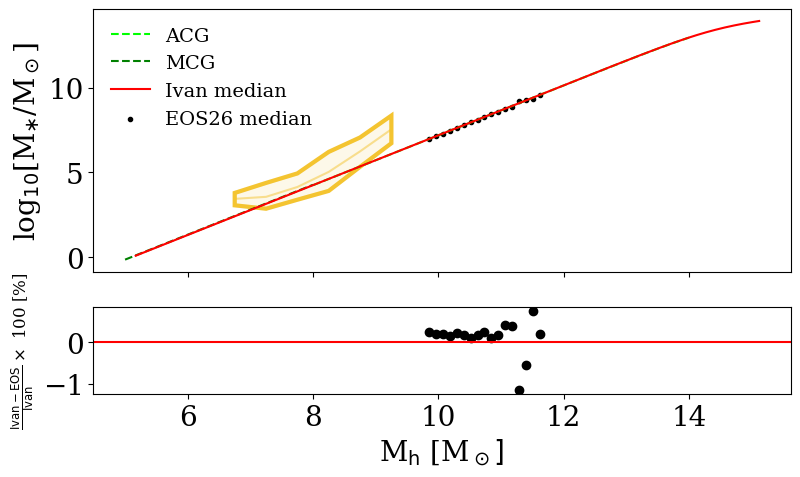

In [33]:
###################SHMR PLOT###################
M_h_ACG = np.log10(np.logspace(8,14,1000))
SHMR_ACG = get_M_ast_v4(F_STAR10, ALPHA_STAR, M_h_ACG, 
                        M_pivot=UPPER_STELLAR_TURNOVER_MASS, 
                        alpha_ast_2 = UPPER_STELLAR_TURNOVER_INDEX, 
                        M_turn=M_turn)

M_h_MCG = np.log10(np.logspace(5,8,1000))
SHMR_MCG = get_M_ast(F_STAR7_MINI, ALPHA_STAR_MINI, M_h_MCG, M=7)

# these are 1sigma CLs
M_h_Xu = np.array([6.75,7.25,7.75,8.25,8.75,9.25])
M_ast_mean_normal_Xu = np.array([3.44,3.56,4.14,5.03,6.24,7.54])
M_ast_upper_normal_Xu = np.array([0.35,0.51,0.75,0.74,0.32,0.81])
M_ast_lower_normal_Xu = np.array([0.33,0.58,0.71,0.63,0.42,0.81])

M_ast_mean_void_Xu = np.array([3.26,3.56,4.02,5.11,6.32,7.46])
M_ast_upper_void_Xu = np.array([0.22,0.49,0.61,1.10,0.74,0.12])
M_ast_lower_void_Xu = np.array([0.2,0.46,0.63,1.20,0.99,0.12])

M_ast_mean_rarepeak_Xu = np.array([3.15,3.67,4.20,5.38,6.44,7.23])
M_ast_upper_rarepeak_Xu = np.array([0.02,0.71,0.74,0.78,0.61,0.43])
M_ast_lower_rarepeak_Xu = np.array([0.02,0.81,0.72,0.78,0.45,0.51])

lower_Xu = np.array([M_ast_mean_normal_Xu - M_ast_lower_normal_Xu, M_ast_mean_void_Xu - M_ast_lower_void_Xu, M_ast_mean_rarepeak_Xu - M_ast_lower_rarepeak_Xu])
upper_Xu = np.array([M_ast_mean_normal_Xu + M_ast_upper_normal_Xu, M_ast_mean_void_Xu + M_ast_upper_void_Xu, M_ast_mean_rarepeak_Xu + M_ast_upper_rarepeak_Xu])
Xu_color = "#f4c430"
fig, ax = plt.subplots(nrows=2,ncols=1,figsize = (9,5), gridspec_kw={"height_ratios":[3,1]}, sharex=True)
ax[0].plot(M_h_ACG, SHMR_ACG, label = "ACG", color = "lime", ls = "--")
ax[0].plot(M_h_MCG, SHMR_MCG, label = "MCG", color = "g", ls = "--")
ax[0].plot(M_h_Xu, M_ast_mean_normal_Xu, color = Xu_color, alpha = 0.5)
ax[0].fill(np.append(M_h_Xu, M_h_Xu[::-1]), np.append(np.min(lower_Xu, axis = 0), np.max(upper_Xu, axis = 0)[::-1]), color = Xu_color, alpha = 1, facecolor="none",  edgecolor = Xu_color, linewidth = 3)
ax[0].fill(np.append(M_h_Xu, M_h_Xu[::-1]), np.append(np.min(lower_Xu, axis = 0), np.max(upper_Xu, axis = 0)[::-1]), color = Xu_color, alpha = 0.1, edgecolor = Xu_color, linewidth = 3)

M_h_Ivan = np.log10(np.loadtxt("halo_masses.txt"))
SHMR_Ivan = np.log10(np.loadtxt("median_stellar_masses.txt"))

ax[0].plot(M_h_Ivan, SHMR_Ivan, label = "Ivan median", color = "r")
# ax.scatter(sim_Mh, sim_Mast, color = "k", alpha = 0.1, marker = '.', label = "EOS26")
mh_bins = np.linspace(9.8,12,21)
avg_star = np.zeros(len(mh_bins)-1)
for i in range(len(mh_bins)-1):
    avg_star[i] = np.median(sim_Mast[np.logical_and(sim_Mh>mh_bins[i], sim_Mh<=mh_bins[i+1])])
mh_centres = (mh_bins[1:] + mh_bins[:-1])/2.
ax[0].scatter(mh_centres, avg_star, color = "k",marker = '.', label = "EOS26 median")

# plt.text(5.0, 10.,'Renaissance Xu+16', color = Xu_color)
ax[1].set_xlabel(r'M$_{\rm h}$ [M$_\odot]$')
ax[0].set_ylabel(r'log$_{10}$[M$_{\ast}$/M$_\odot$]')
ax[0].legend(frameon=False, fontsize=14)


from scipy.interpolate import interp1d
ivans = interp1d(M_h_Ivan, SHMR_Ivan)(mh_centres)
ax[1].scatter(mh_centres, (ivans - avg_star) / ivans * 100., color = "k")

ax[1].axhline(0, color = "r")
ax[1].set_ylabel(r"$\frac{\mathrm{Ivan - EOS}}{\mathrm{Ivan}} \times$ 100 [%]", fontsize=12)

plt.savefig(plotspath+"SHMR_EOS25.png", bbox_inches='tight')
plt.show()

# SFMS

In [8]:
M_STAR = np.log10(np.logspace(5, 12, 100))

SFMS = get_SFMS(M_STAR, t_STAR, 10.)
Santini_z5 = get_Santini17_SFMS(10**M_STAR, 5)
Santini_z6 = get_Santini17_SFMS(10**M_STAR, 6)

Rinaldi_z5 = get_Rinaldi22_SFMS(10**M_STAR, 5)
Rinaldi_z6 = get_Rinaldi22_SFMS(10**M_STAR, 6)

M_star_Ivan = np.log10(np.loadtxt("stellar_masses_SFMS.txt"))
SFR_Ivan = np.log10(np.loadtxt("median_SFR.txt"))

In [9]:
#Over all zs, take halo masses and stellar masses
# sim_Mast = []
halo_catalog = get_halo_catalog_from_PHF(10., runcache, match_z_within=0.1)
m = halo_catalog["halo_mass"]>0
sim_Mh = halo_catalog["halo_mass"][m]
sim_Mast = halo_catalog["halo_stars"][m]
sim_SFR = halo_catalog["halo_sfr"][m]
print(len(sim_Mast))
sim_Muv = get_muv_fromSFRMast(sim_SFR, sim_Mast, redshift=10.)
sim_Mast = np.log10(sim_Mast)
# sim_SFR *= un.year.to(un.s)
sim_SFR = np.log10(sim_SFR)
sim_Mh = np.log10(sim_Mh)

457804


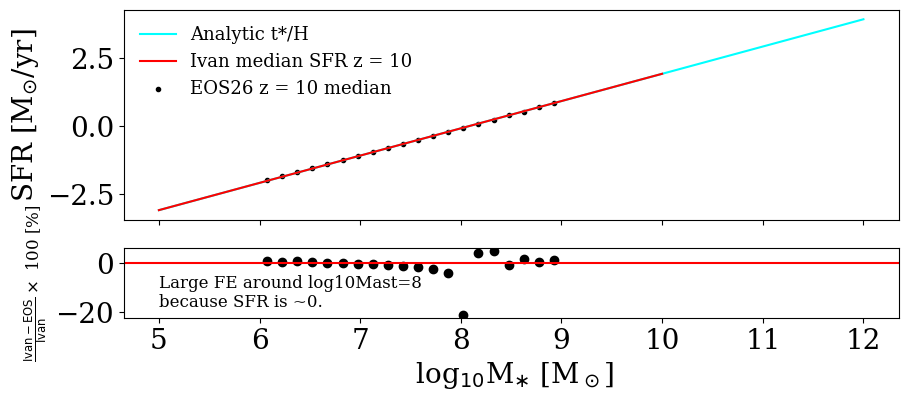

In [41]:
fig, ax = plt.subplots(nrows=2,ncols=1,sharex=True,figsize = (10,4), gridspec_kw={"height_ratios":[3,1]})
ax[0].plot(M_STAR, SFMS[0,:], color = "cyan", label = "Analytic t*/H")
# plt.plot(M_STAR, Santini_z5, label = r"Santini+17 HST 4 $\leq$ z < 5", ls = "--", color = "g")
# plt.plot(M_STAR, Santini_z6, label = r"Santini+17 HST 5 $\leq$ z < 6", ls = "--", color = "lime")

# plt.plot(M_STAR, Rinaldi_z5, label = r"Rinaldi+22 JWST 4 $\leq$ z < 5", ls = "--", color = "k")
# plt.plot(M_STAR, Rinaldi_z6, label = r"Rinaldi+22 JWST 5 $\leq$ z < 6.5", ls = "--", color = "grey")
ax[0].plot(M_star_Ivan, SFR_Ivan, color = "r",label = "Ivan median SFR z = 10")
mast_bins = np.linspace(6,9,21)
median_sfr = np.zeros(len(mast_bins)-1)
for i in range(len(mast_bins)-1):
    median_sfr[i] = np.median(sim_SFR[np.logical_and(sim_Mast>mast_bins[i], sim_Mast<=mast_bins[i+1])])
mast_centres = (mast_bins[1:] + mast_bins[:-1])/2.
# ax.scatter(sim_Mast, sim_SFR, color = "k", alpha = 0.1, marker = '.', label = "EOS26 z = 10")
ax[0].scatter(mast_centres, median_sfr, color = "k",marker = '.', label = "EOS26 z = 10 median")

ax[1].set_xlabel(r" log$_{10}$M$_{\ast}$ [M$_\odot$]")
ax[0].set_ylabel(r'SFR [M$_{\odot}$/yr]')
ax[0].legend(fontsize = 13, frameon=False, loc = 2)

from scipy.interpolate import interp1d
ivans = interp1d(M_star_Ivan, SFR_Ivan)(mast_centres)
ax[1].scatter(mast_centres, (ivans - median_sfr) / ivans * 100., color = "k")
ax[1].text(5,-18,f"Large FE around log10Mast=8 \nbecause SFR is ~0.", fontsize=12)
ax[1].axhline(0, color = "r")
ax[1].set_ylabel(r"$\frac{\mathrm{Ivan - EOS}}{\mathrm{Ivan}} \times$ 100 [%]", fontsize=12)
plt.savefig(plotspath+"SFR_EOS25.png", bbox_inches='tight')
plt.show()

# Mh-Muv

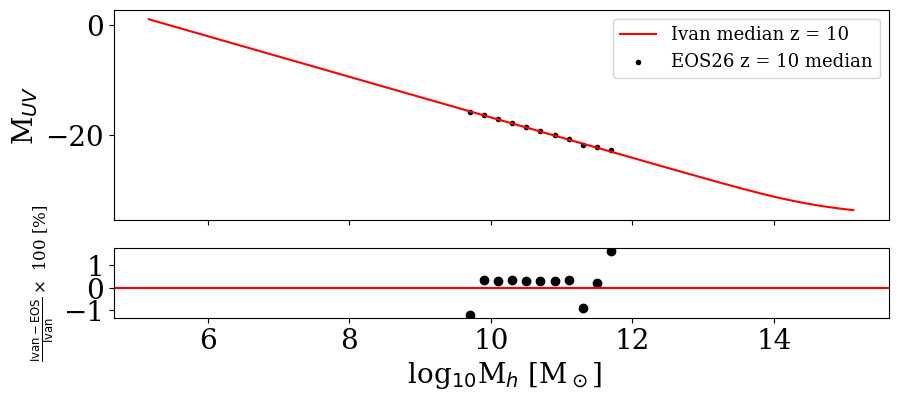

In [43]:
M_h_Ivan = np.log10(np.loadtxt("halo_masses_Muv.txt"))
Muv_Ivan = np.loadtxt("median_Muv_Ivan.txt")
fig, ax = plt.subplots(nrows=2,ncols=1,figsize = (10,4), sharex=True, gridspec_kw={"height_ratios":[3,1]})

ax[0].plot(M_h_Ivan, Muv_Ivan, label = "Ivan median z = 10", color = "r")
mh_bins = np.linspace(7,15,41)
avg_muv = np.zeros(len(mh_bins)-1)
for i in range(len(mh_bins)-1):
    avg_muv[i] = np.median(sim_Muv[np.logical_and(sim_Mh>mh_bins[i], sim_Mh<=mh_bins[i+1])])
mh_centres = (mh_bins[1:] + mh_bins[:-1])/2.
ax[0].scatter(mh_centres, avg_muv, color = "k",marker = '.', label = "EOS26 z = 10 median")

ax[1].set_xlabel(r" log$_{10}$M$_{h}$ [M$_\odot$]")
ax[0].set_ylabel(r'M$_{UV}$')
ax[0].legend(fontsize = 13, loc = 1)

from scipy.interpolate import interp1d
ivans = interp1d(M_h_Ivan, Muv_Ivan)(mh_centres)
ax[1].scatter(mh_centres, (ivans - avg_muv) / ivans * 100., color = "k")
ax[1].axhline(0, color = "r")
ax[1].set_ylabel(r"$\frac{\mathrm{Ivan - EOS}}{\mathrm{Ivan}} \times$ 100 [%]", fontsize=12)
plt.savefig(plotspath+"Mh_Muv_EOS25.png", bbox_inches='tight')
plt.show()

# HMF

In [12]:
import numpy as np
from matplotlib import cm
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, Normalize

import py21cmfast as p21c
p21c.config['EXTRA_HALOBOX_FIELDS'] = True
# plt.rcParams["figure.figsize"] = [16, 8]

#we use the HMF package (github.com/halomod/hmf) to verify our outputs
from hmf import MassFunction
from powerbox import get_power

In [13]:
#set up some histogram parameters for plotting hmfs
edges = np.logspace(7, 13, num=64)
widths = np.diff(edges)
dlnm = np.log(edges[1:]) - np.log(edges[:-1])
centres = (edges[:-1] * np.exp(dlnm / 2)).astype("f4")
volume = inputs.simulation_options.BOX_LEN**3
little_h = inputs.cosmo_params.cosmo.H0.to("km s-1 Mpc-1") / 100

In [14]:
import hmf
from astropy.cosmology import Planck18 as cosmo
z=10.
hmf_loc = hmf.MassFunction(
            z=z,
            Mmin=5,
            Mmax=19,
            dlog10m=0.05,
            hmf_model="SMT"
        )
logm_to_check = np.log10(hmf_loc.m / cosmo.h)
dndlog10m_to_check = hmf_loc.dndlog10m * cosmo.h**3 * np.exp(- 5e8 / (hmf_loc.m / cosmo.h) )

/home/dbreitman/.conda/envs/21cmFASTv4/lib/python3.12/site-packages/hmf/density_field/transfer_models.py:232: UserWarning: 'extrapolate_with_eh' was not set. Defaulting to True, which is different behaviour than versions <=3.4.4. This warning may be removed in v4.0. Silence it by setting extrapolate_with_eh explicitly.
  warnings.warn(


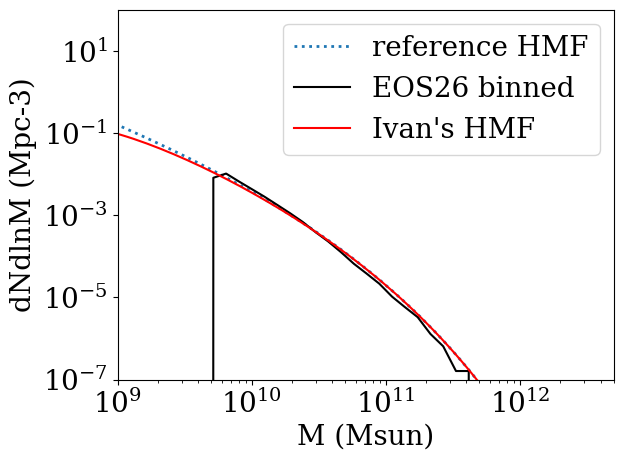

In [15]:
# get the mass function
halo_catalog = get_halo_catalog_from_PHF(10., runcache, match_z_within=0.1)
masses = halo_catalog.get('halo_mass')
hist, _ = np.histogram(masses, edges)
mf = hist / volume / dlnm
plt.loglog(
    hmf_loc.m / little_h,
    hmf_loc.dndlnm * (little_h**3),
    color="C0",
    linewidth=2,
    linestyle=":",
    label="reference HMF",
)
plt.loglog(centres, mf, color="k", label="EOS26 binned")
plt.plot(10**logm_to_check, dndlog10m_to_check / np.log(10), color = "r", label="Ivan's HMF")

plt.xlim([1e9, 5e12])
plt.ylim([1e-7, 1e2])
plt.ylabel("dNdlnM (Mpc-3)")
plt.xlabel("M (Msun)")
plt.legend()
plt.show()

# UVLFs

In [18]:
uvlfs_ivan = np.loadtxt("Ivan_UVLFs.txt")
ivan_muv = np.linspace(-23, -17, 10)
ivan_zs = [6,7,8,9,10,11,12.5,14.5]

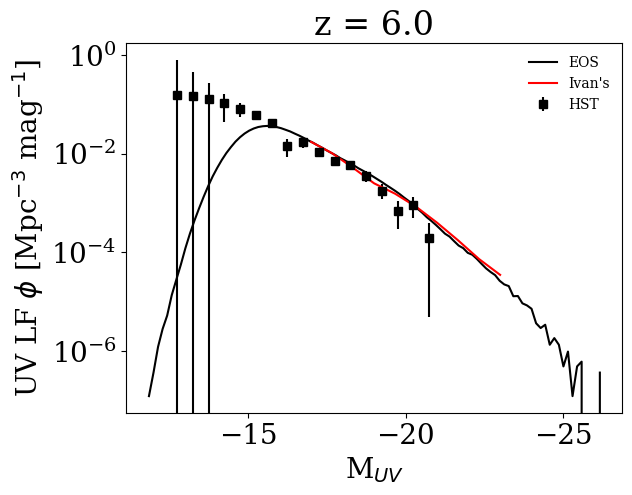

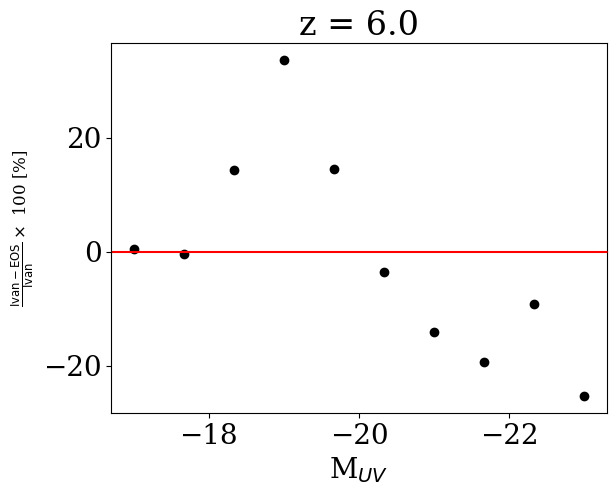

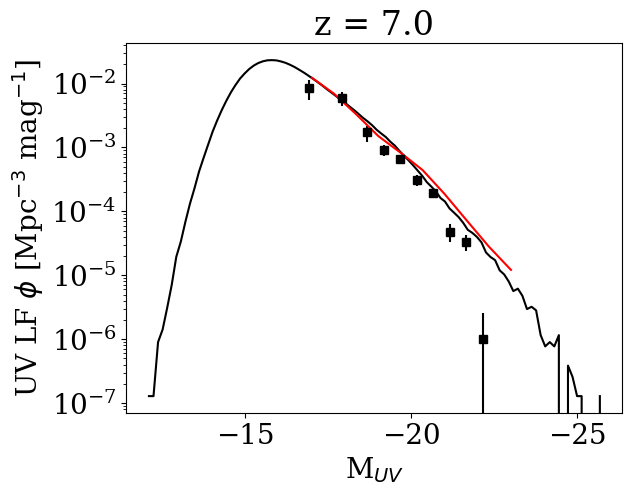

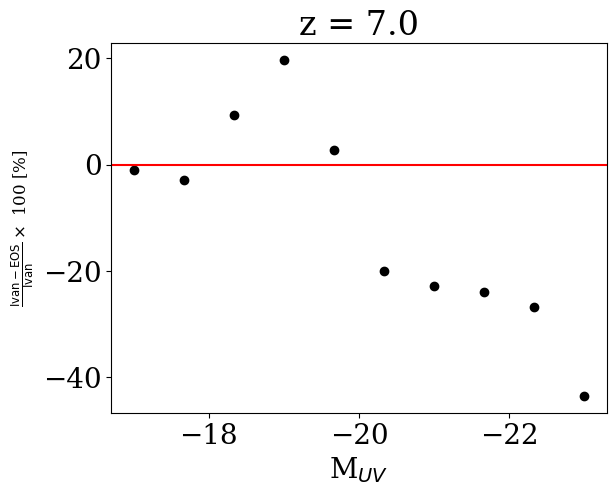

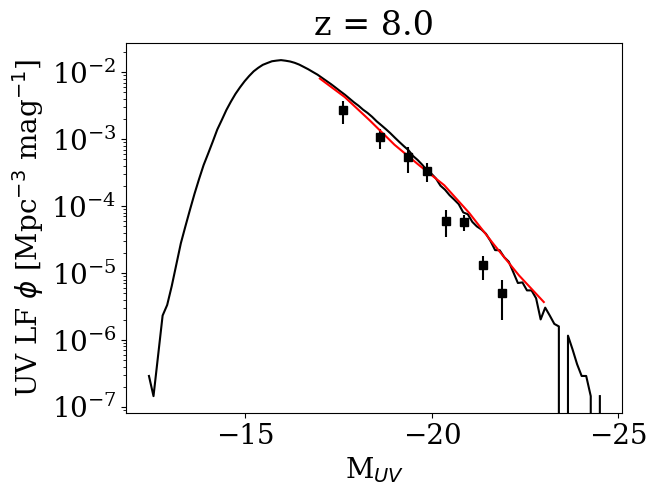

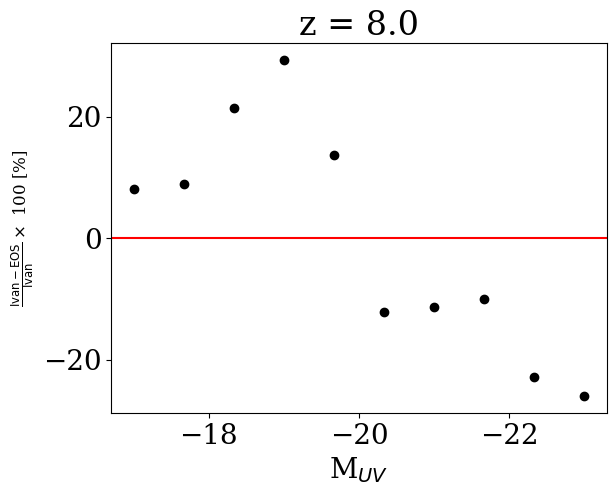

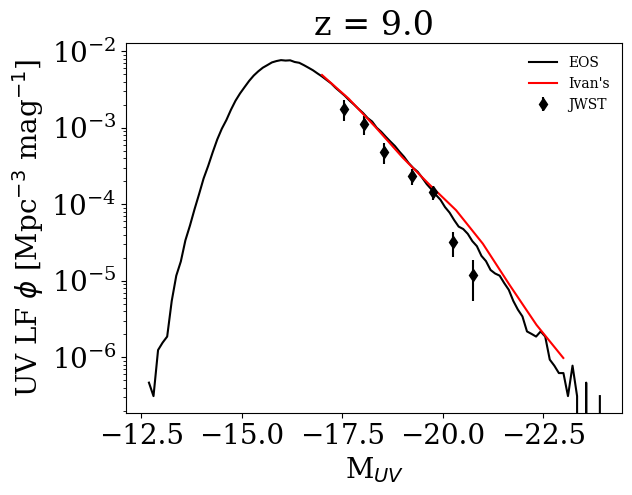

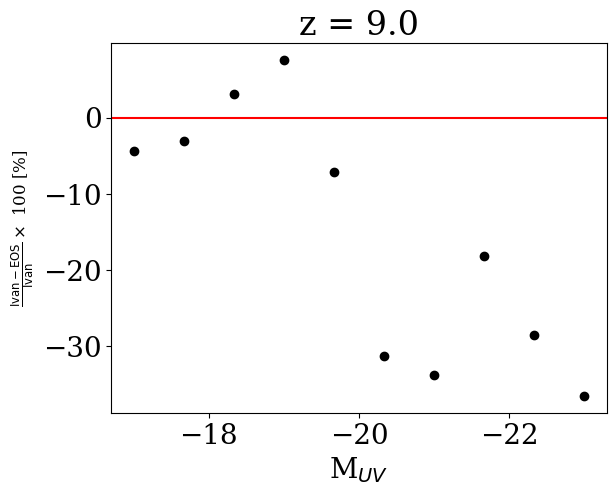

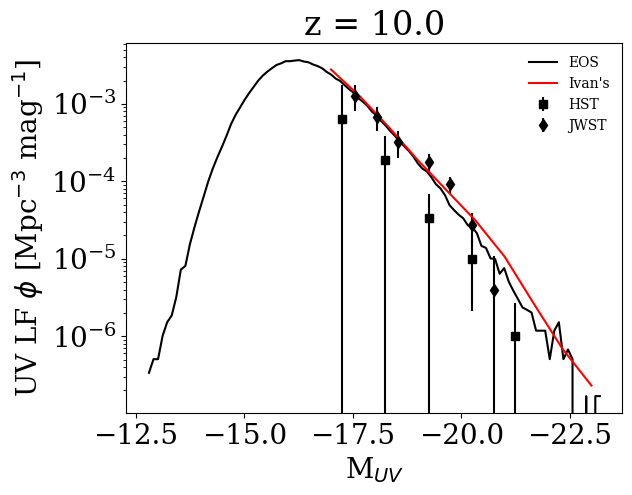

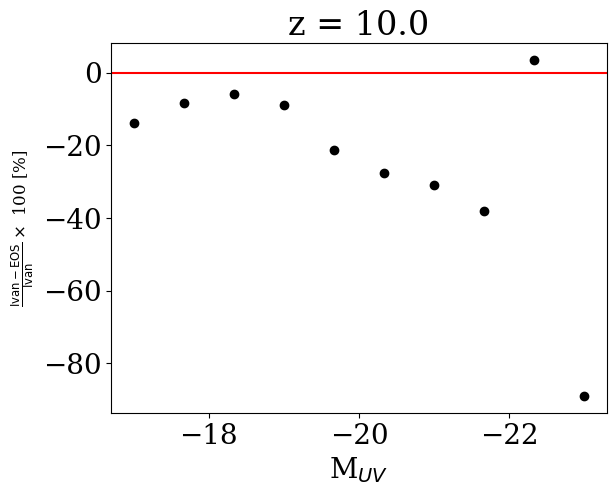

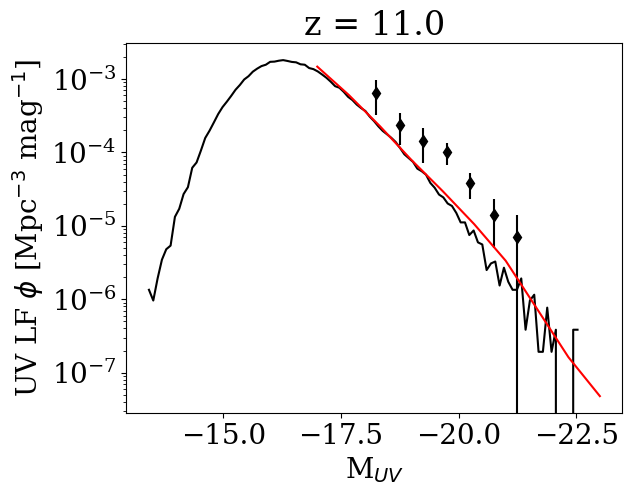

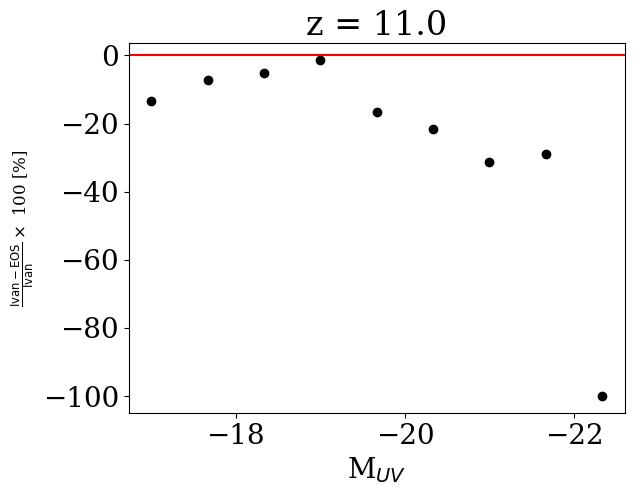

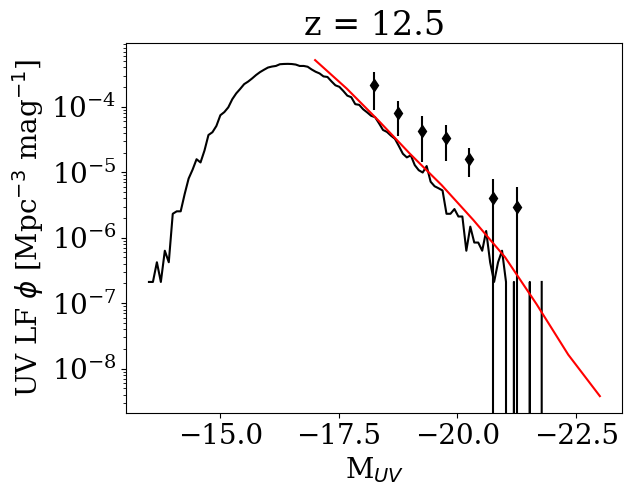

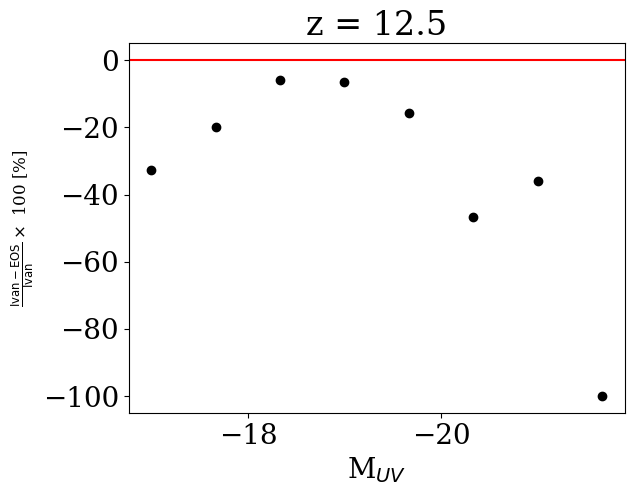

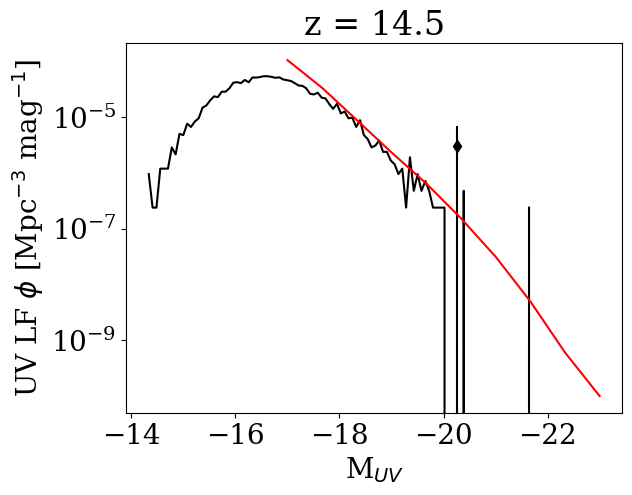

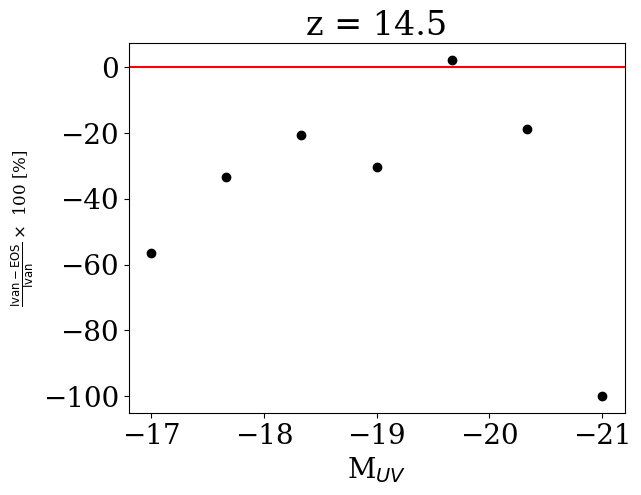

In [44]:
####################UVLFs PLOT###################
uvlf_redshifts = [6.,7.,8.,9.,10., 11., 12.5, 14.5]
uvlfs = {}
for redshift in uvlf_redshifts:
    halo_catalog = get_halo_catalog_from_PHF(redshift, runcache, match_z_within=0.1)
    uvlfs[str(redshift)] = get_uvlf(redshift, halo_catalog, inputs, bins=100, K_UV=interp_kuv)

data_path = "/home/dbreitman/jeanzay/21CMMC_old/src/py21cmmc/data/"
for i,redshift in enumerate(uvlf_redshifts):
    try:
        if redshift <= 11.:
            zstr = str(int(redshift))
        else:
            zstr = str(int(np.floor(redshift))) + "pt5"
        Donnan_Muv = np.load(data_path+"Donnan24_LF_lfuncs_z"+zstr+".npz", allow_pickle=True)["Muv"]
        Donnan_LF = np.load(data_path+"Donnan24_LF_lfuncs_z"+zstr+".npz", allow_pickle=True)["lfunc"]
        Donnan_sigma = np.load(data_path+"Donnan24_LF_sigmas_z"+zstr+".npz", allow_pickle=True)["sigma"]
    except:
        Donnan_Muv = Donnan_LF = Donnan_sigma = None
        
    try:
        zstr = str(int(redshift))
        Bouwens_Muv = np.load(data_path+"LF_lfuncs_z"+zstr+".npz", allow_pickle=True)["Muv"]
        Bouwens_LF = np.load(data_path+"LF_lfuncs_z"+zstr+".npz", allow_pickle=True)["lfunc"]
        Bouwens_sigma = np.load(data_path+"LF_sigmas_z"+zstr+".npz", allow_pickle=True)["sigma"]
    except:
        Bouwens_Muv = Bouwens_LF = Bouwens_sigma = None
    
    if Bouwens_Muv is not None:
        plt.errorbar(Bouwens_Muv, Bouwens_LF, yerr = Bouwens_sigma, color = "k", label = "HST", ls = "none", marker = "s")
    if Donnan_Muv is not None:
        plt.errorbar(Donnan_Muv, Donnan_LF, yerr = Donnan_sigma, color = "k", label = "JWST", ls = "none", marker = "d")
    plt.plot(uvlfs[str(redshift)]["M_uv"], uvlfs[str(redshift)]["lfunc"], color = "k", label = "EOS")
    plt.plot(ivan_muv, uvlfs_ivan[i], color = "r", label = "Ivan's")
    plt.xlabel(r"M$_{UV}$")
    plt.ylabel(r"UV LF $\phi$ [Mpc$^{-3}$ mag$^{-1}$]")
    ax = plt.gca()
    ax.xaxis.set_inverted(True)
    plt.yscale("log")
    if redshift == 6.0 or redshift == 9.0 or redshift == 10.:
        plt.legend(frameon=False, fontsize = 10, loc = 1)
    plt.title("z = " + str(redshift))
    plt.savefig(plotspath+"UVLF_z"+str(redshift).replace(".","pt")+"_EOS25.png", bbox_inches='tight')
    plt.show()

    plt.title("z = " + str(redshift))

    eos = interp1d(uvlfs[str(redshift)]["M_uv"], uvlfs[str(redshift)]["lfunc"], bounds_error=False)(ivan_muv)
    plt.scatter(ivan_muv, (eos - uvlfs_ivan[i]) / uvlfs_ivan[i] * 100., color = "k")
    plt.axhline(0, color = "r")
    plt.xlabel(r"M$_{UV}$")
    plt.ylabel(r"$\frac{\mathrm{Ivan - EOS}}{\mathrm{Ivan}} \times$ 100 [%]", fontsize=12)
    ax = plt.gca()
    ax.xaxis.set_inverted(True)
    plt.show()

# EoR history

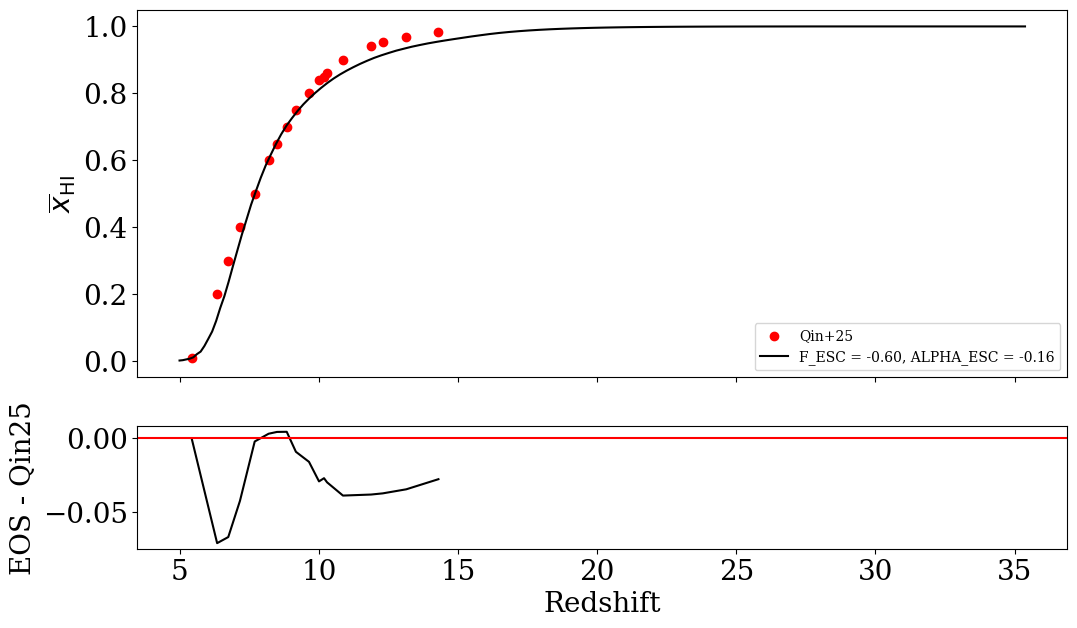

In [45]:
####################xHI PLOT###################
from scipy.interpolate import interp1d

Qin25_z = [5.44, 6.35, 6.75, 7.17, 7.7, 8.2, 8.5, 8.85, 9.18, 9.65, 10.01, 10.19, 10.30, 10.87, 11.88, 12.30, 13.144, 14.30]
Qin25_xHI = [0.01, 0.2, 0.3, 0.4, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.84, 0.85, 0.86, 0.9, 0.94, 0.952, 0.96947, 0.9822]

fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(12,7), gridspec_kw={'height_ratios':[3,1]}, sharex=True)
ax[0].scatter(Qin25_z, Qin25_xHI, color = "r", label = "Qin+25")
ax[0].plot(lightcone.inputs.node_redshifts, 
           lightcone.global_quantities["neutral_fraction"], 
           color = "k", 
           label = "F_ESC = %.2f, ALPHA_ESC = %.2f"%(F_ESC10, ALPHA_ESC))
ax[1].plot(Qin25_z, 
         interp1d(lightcone.inputs.node_redshifts, lightcone.global_quantities["neutral_fraction"])(Qin25_z) - Qin25_xHI,
         color = "k")
ax[1].set_xlabel("Redshift")
ax[0].set_ylabel(r"$\overline{x}_{\rm HI}$")
ax[1].set_ylabel(r"EOS - Qin25")
ax[1].axhline(0, color = 'r')
ax[0].legend(fontsize = 10)
plt.savefig(plotspath+"xHI_EOS25.png", bbox_inches='tight')
plt.show()

# Thomson scattering optical depth

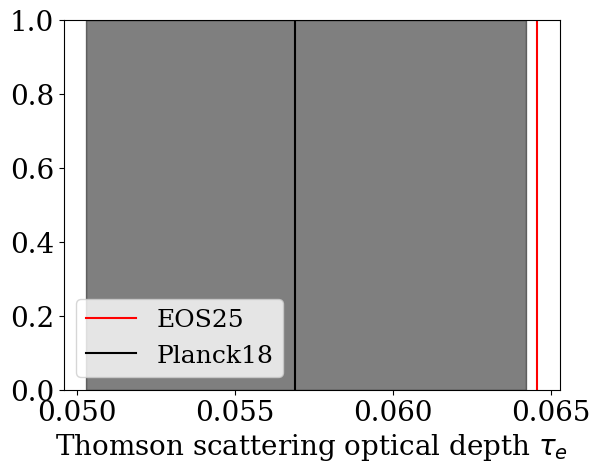

In [23]:
####################Tau PLOT###################
tau_EOS25 = p21c.compute_tau(
                redshifts=lightcone.inputs.node_redshifts[::-1],
                global_xHI=lightcone.global_quantities["neutral_fraction"][::-1],
                inputs=lightcone.inputs,
            )
tau_mean=0.0569
tau_sigma_u=0.0073
tau_sigma_l=0.0066

plt.axvline(tau_EOS25, color = "r", label = "EOS25")
plt.axvline(tau_mean, color = "k", label = "Planck18")
plt.axvspan(tau_mean - tau_sigma_l, tau_mean + tau_sigma_u, color = "k", alpha = 0.5)
plt.xlabel(r"Thomson scattering optical depth $\tau_e$")
plt.legend(loc = 3, fontsize=18)
plt.savefig(plotspath+"tau_EOS25.png", bbox_inches='tight')
plt.show()

# Lightcones

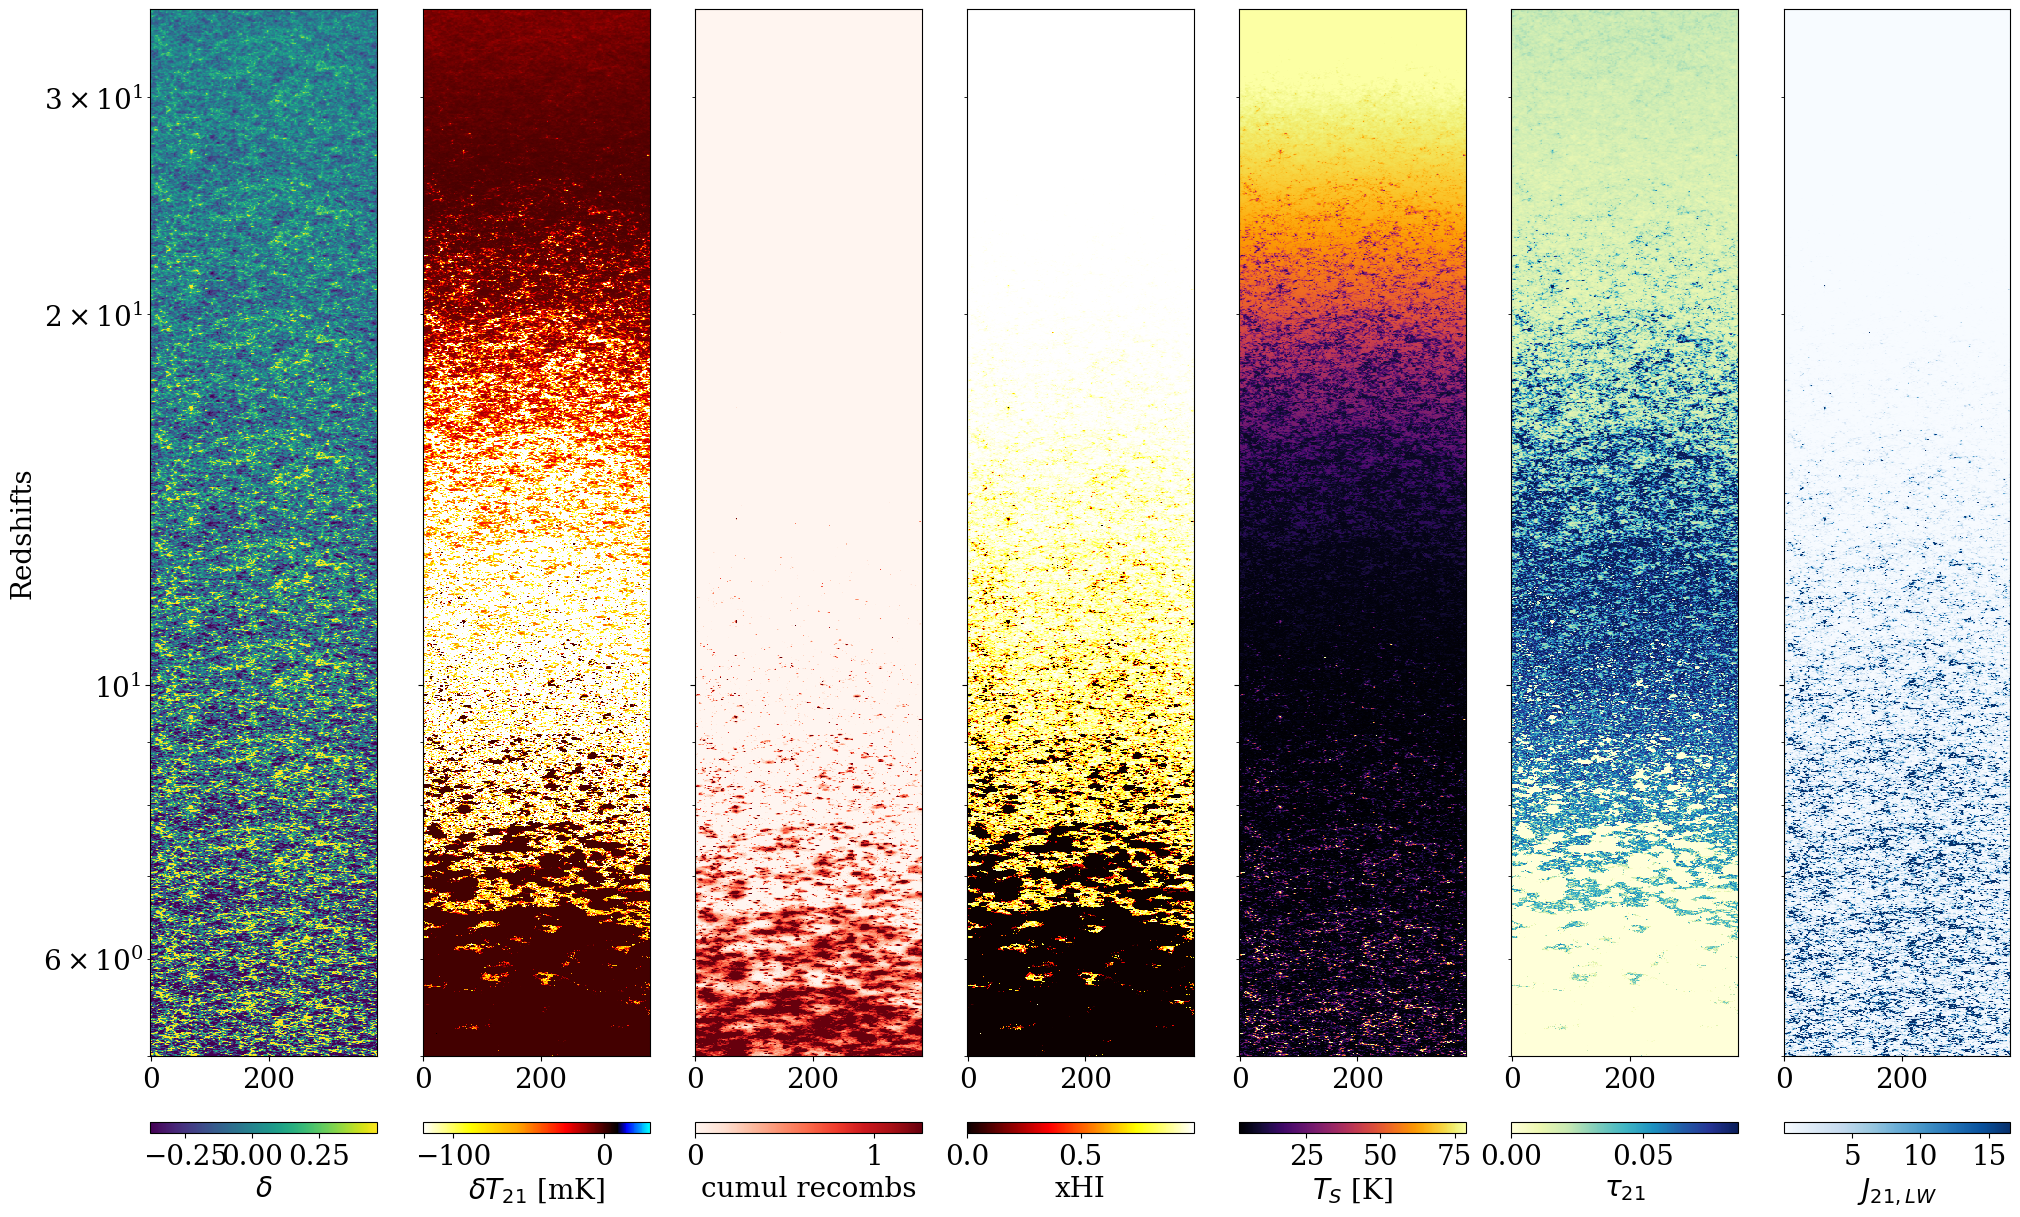

In [24]:
####################PLOT LC###################
keys = ["density", "brightness_temp", "cumulative_recombinations", "neutral_fraction", "spin_temperature", "tau_21", "J_21_LW"]
key_names = [r"$\delta$", r"$\delta T_{21}$ [mK]", "cumul recombs", "xHI", r"$T_S$ [K]", r"$\tau_{21}$", r"$J_{21,LW}$"]
cmaps = ["viridis", "EoR", "Reds", "hot","inferno","YlGnBu", "Blues"]
fig, axs = plt.subplots(nrows=1, ncols = 7, sharey=True, figsize = (24,17))
for i,k,k_name, c in zip(range(len(keys)), keys, key_names, cmaps):
    im = axs[i].pcolormesh(np.linspace(0,BOX_LEN, HII_DIM),
                     lightcone.lightcone_redshifts,
                     lightcone.lightcones[k][0,...].T,
                     vmin = np.nanpercentile(lightcone.lightcones[k][0,...],5) if c != "EoR" else -120,
                     vmax = np.nanpercentile(lightcone.lightcones[k][0,...],95) if c != "EoR" else 30,
                     cmap = c)
    cb = plt.colorbar(im,
            orientation="horizontal",
            ax=axs[i],
            label = k_name,
            pad=0.05,
        )
    axs[i].set_yscale("log")
axs[0].set_ylabel("Redshifts")
plt.savefig(plotspath+"lightcones_EOS25.png", bbox_inches='tight')
plt.show()

# Global quantities

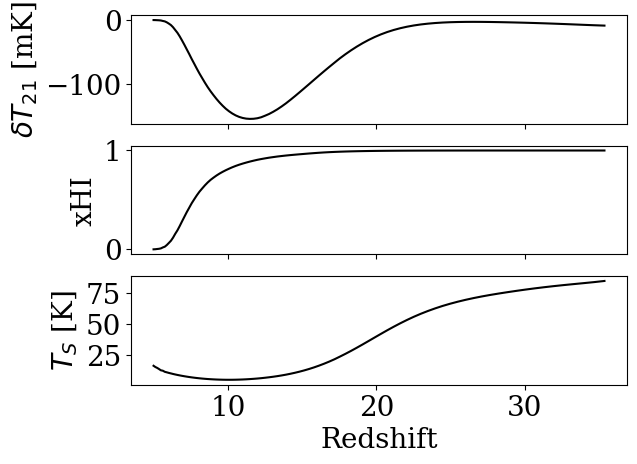

In [25]:
keys = ["brightness_temp","neutral_fraction", "spin_temperature"]
key_names = [r"$\delta T_{21}$ [mK]", "xHI", r"$T_S$ [K]"]
fig, axs = plt.subplots(ncols=1, nrows = 3, sharex=True)
for i,k, k_name in zip(range(len(keys)), keys, key_names):
    axs[i].plot(lightcone.inputs.node_redshifts, 
           lightcone.global_quantities[k], 
                color = "k")
    axs[i].set_ylabel(k_name)
axs[-1].set_xlabel("Redshift") 
plt.savefig(plotspath+"globals_EOS25.png", bbox_inches='tight')
plt.show()